# Project: Wrangling and Analyze Data

## Table of Contents
1. [Import packages](#import)
2. [Data Gathering](#gathering)
3. [Assessing Data](#assess)
4. [Cleaning Data](#cleaning)
5. [Storing Data](#storing)
6. [Analyzing and Visualizing Data](#analyzing)
7. [Resources](#resources)

## Import packages
<div id='import'/>

In [1]:
import requests
import tweepy
import json

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import pandas.api.types as ptypes

from wordcloud import WordCloud
from IPython.display import Image

## Data Gathering
<div id='gathering'/>

### I. Directly downloading the WeRateDogs Twitter archive data (`twitter_archive_enhanced.csv`)

In [2]:
rate_df = pd.read_csv('../datasets/twitter-archive-enhanced.csv')
rate_df.shape

(2356, 17)

### II. Using the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('../datasets/image_predictions.tsv', 'wb') as file:
    file.write(response.content)

predictions_df = pd.read_csv('../datasets/image_predictions.tsv', sep='\t')
predictions_df.shape

(2075, 12)

### III. Using the Tweepy library to query additional data via the Twitter API (saved as `tweet_json.txt`)

Prerequisite
* [Sign up for twitter account](https://help.twitter.com/en/using-twitter/create-twitter-account) then [sign up for developer account](https://developer.twitter.com/en/docs/developer-portal/overview).
* [Apply for elevated access](https://developer.twitter.com/en/portal/products/elevated).

Problems while accessing twitter API
<div id='api_problems' />

1. Valid SSL certificate is necessary to [secure the jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/public_server.html#securing-a-notebook-server) server. Afterwards data can be requested from the twitter API.
2. Company firewall blocks the twitter API requests.

#### 1. Solution to gather tweet data using twitter API
* Data is downloaded via Udacity workspace, see [problems](#api_problems).
* Note that the `wait_on_rate_limit_notify` params does not exist for the current [API](https://docs.tweepy.org/en/stable/api.html) class anymore.

In [4]:
CONSUMER_KEY = ''
CONSUMER_SECRET = ''
ACCESS_TOKEN = ''
ACCESS_TOKEN_SECRET = ''

In [ ]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Request all the tweets by the `tweet_id` which is stored in the `rate_df` dataframe. If the tweet does not exist then capture its `tweet_id` in the `tweets_not_exist` list.

In [ ]:
tweets_exist = []
tweets_not_exist = []
for tweet_id in rate_df['tweet_id']:   
    try:
        tweets_exist.append(api.get_status(tweet_id))
    except Exception as e:
        tweets_not_exist.append(tweet_id)

print("Number of existed tweets ", len(tweets_exist))
print("Number of not existed tweets ", len(tweets_not_exist))

Save the the tweets into the `text_json.txt` text file.

In [ ]:
tweet_dict = []
for tweet in tweets_exist:
    tweet_dict.append(tweet)

# Serialize to a json formatted text file
with open('tweet_json.txt', 'w') as file:
    file.write(json.dumps(tweet_dict, indent=4))

#### 2. Alternative solution to gather tweet data

In [ ]:
# Download file using Requests library via URL provided 
url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
response = requests.get(url, verify=False)

# Save the file
with open('tweet-json_alternative.txt', mode = 'wb') as file:
    file.write(response.content)

In [5]:
# Read downloaded txt file line by line into a pandas DataFrame
df_list = []
with open('../datasets/tweet_json.txt', 'r') as file:
    all_tweets = json.load(file)
    for tweet in all_tweets:
        df_list.append({'tweet_id': tweet['id'],
                        'retweet_count': tweet['retweet_count'],
                        'favorite_count': tweet['favorite_count']})
        
tweet_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
tweet_df.shape

(2326, 3)

## Assessing Data
<div id='assess'/>

In this section, **quality** and **tidiness** issues will be documented. The data will be assesed **visually** and **programmaticaly**.

Data quality dimensions:

* Completeness
* Validity
* Accuracy
* Consistency

Tidy data requirements:

* Each variable forms a column
* Each observation forms a row
* Each type of observational unit forms a table

### Twitter Archive Dataset

In [6]:
rate_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


Observations
* `expanded_urls` can contains multiple link if the tweet has multiple pictures. Picture links is seperated by commas (',').
* `rating_numerator` and `rating_denominator` are probably parsed by regex which retrieve only the first rating with a specified expression `r'digit+/digit+'`. Whenever there is more than one dogs then $denominator = 10 * \#dogs$
* `name` is usually "None" when the pictures show another animal than dog. The name of the dog is also gathered by regual expressions like `r'This is (dogname)(spec_char)'` and `r'Meet (dogname)(spec_char)'`.

In [7]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
rate_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [9]:
rate_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [10]:
rate_df['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

### Dogs Image Prediction Dataset

In [11]:
predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Observations
* There are three prediction called `p1`, `p2`, and `p3`. The prediction probabilites ranges from [0-1] and add up to 1. Predictions could be another than dogs. Probably the model was trained on the subset of [imagenet](https://www.image-net.org/) dataset.

In [12]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [14]:
predictions_df.jpg_url[predictions_df.jpg_url.duplicated()]

1297    https://pbs.twimg.com/ext_tw_video_thumb/67535...
1315      https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg
1333      https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg
1345      https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg
1349      https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg
                              ...                        
1903      https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg
1944      https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg
1992      https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg
2041      https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg
2055      https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg
Name: jpg_url, Length: 66, dtype: object

In [15]:
print('First prediction label count: ', predictions_df.p1.nunique(), \
    'Second prediction label count: ', predictions_df.p2.nunique(), \
    'Third prediction label count: ', predictions_df.p2.nunique())

First prediction label count:  378 Second prediction label count:  405 Third prediction label count:  405


In [16]:
probabilites_sum = (predictions_df.p1_conf + predictions_df.p2_conf + predictions_df.p3_conf)
print(probabilites_sum)
print(probabilites_sum.mean())

0       0.683168
1       0.653028
2       0.851242
3       0.991582
4       0.958622
          ...   
2070    0.956701
2071    0.379200
2072    0.825644
2073    0.483184
2074    0.259010
Length: 2075, dtype: float64
0.7894610417329564


### Tweet API dataset

In [17]:
tweet_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6953,33624
1,892177421306343426,5255,29162
2,891815181378084864,3462,21941
3,891689557279858688,7171,36700
4,891327558926688256,7701,35097


In [18]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2326 non-null   int64
 1   retweet_count   2326 non-null   int64
 2   favorite_count  2326 non-null   int64
dtypes: int64(3)
memory usage: 54.6 KB


In [19]:
tweet_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.326000e+03,2326.000000,2326.000000
mean,7.417346e+17,2453.592863,7014.404127
std,6.816442e+16,4153.567570,10895.745057
min,6.660209e+17,1.000000,0.000000
25%,6.780814e+17,493.000000,1218.750000
50%,7.178159e+17,1143.000000,3031.500000
75%,7.986402e+17,2841.500000,8554.500000
max,8.924206e+17,70107.000000,143847.000000


### Quality issues

`rate_df` data frame
* NaN values in the `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls` columns. (**Completeness**)
* `timestamp` should be datetime instead of string, if we want to retrieve information about time. (**Validity**)
* `rating_numerator` is sometimes wrong for example at *832215726631055000* it is 75/10 instead of 9.75/10. Ratings numerators [0-1776] and denominators [0-170] are inconsistent range. Furthuremore the ratings are ambigous for example at *667878741721416000* 10&amp;2/10 rate and *695064344191721000* "4/10 for Charles the puppy, 13/10 overall". (**Accuracy**)
* `rating_denominator` is inconsistent. Mostly is 10 but times when more dogs are on the picture it increased according to the number of dogs. (**Consistency**)
* `source` is string, however it has four distinct values. It could be categorical (iphone, vine, web, tweetdeck) value. (**Consistency**)
* `name` is a string and contains inaccurate names like 'a', 'an', 'O' due to the regular expression. (**Accuracy**)

`predictions_df` data frame
* `jpg_url` columns has duplicated values. Duplicated rows are next to each others and randomly distributed accross the dataset. (**Completeness**)
* `p1_conf`, `p2_conf`, and `p3_conf` probabilites do not add up to one. (**Consistency**)

### Tidiness issues

`rate_df` data frame
* `doggo`, `floofer`, `pupper`, `puppo` are all dog types. It should be one column. (**Variable forms a column**)
* `tweet_id` should be string instead of integer, because we want to merge them together instead of doing operations (add, substract, average) on them. (**Observational unit forms a table**)

`predictions_df` data frame
* `tweet_id` should be string instead of integer in order to merge the tables together. (**Observational unit forms a table**)
* `img_num` column should be at the `rate_d` dataset, because it indicates how many image in the tweet. In other words how many links were in the `expanded_urls` columns seperated by commas. (**Observational unit forms a table**)

`tweet_df` data frame
* `tweet_id` should be string instead of integer. (**Observational unit forms a table**)

## Cleaning Data
<div id='cleaning'/>

* Copy the orignal datasets before cleaning
* Clean the datasets according to the [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)
* Create a master data frame(s)

In [20]:
# Make copies of original pieces of data
rate_copy = rate_df.copy()
predictions_copy = predictions_df.copy()
tweet_copy = tweet_df.copy()

### Data frame `rate_df` wrong identifier type:

#### Define
Cast `tweet_id` to string type

#### Code

In [21]:
rate_copy.tweet_id = rate_copy.tweet_id.map(str)

#### Test

In [22]:
print(rate_copy.tweet_id.dtype)
assert pd.api.types.is_string_dtype(rate_copy.tweet_id)

object


### Data frame `predictions_df` wrong identifier data type:

#### Define
Cast `tweet_id` to string then merge the `predictions_clean` data frame with `rate_clean` data frame.

#### Code

In [23]:
predictions_copy.tweet_id = predictions_copy.tweet_id.map(str)
master_df = pd.merge(rate_copy, predictions_copy, on=['tweet_id'], how='inner')

#### Test

In [24]:
assert pd.api.types.is_string_dtype(predictions_copy.tweet_id)

### Data frame `tweet_df` wrong identifier data type:

#### Define
Cast `tweet_id` to string then merge the `tweet_clean` data frame with `master_df` data frame.

#### Code

In [25]:
tweet_copy.tweet_id = tweet_copy.tweet_id.map(str)
master_df = pd.merge(master_df, tweet_copy, on=['tweet_id'], how='inner')

#### Test

In [26]:
assert pd.api.types.is_string_dtype(tweet_copy.tweet_id)
master_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

### Data frame `rate_df` missing values:

#### Define:
Drop the `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls` columns, because they are not necessary for further analysis.

#### Code

In [27]:
master_copy = master_df.dropna(axis=1).copy()
master_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog',
       'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count',
       'favorite_count'],
      dtype='object')

#### Test

In [28]:
has_missing_values = master_copy.isna().any()
print(has_missing_values)
assert has_missing_values.sum() == 0

tweet_id              False
timestamp             False
source                False
text                  False
expanded_urls         False
rating_numerator      False
rating_denominator    False
name                  False
doggo                 False
floofer               False
pupper                False
puppo                 False
jpg_url               False
img_num               False
p1                    False
p1_conf               False
p1_dog                False
p2                    False
p2_conf               False
p2_dog                False
p3                    False
p3_conf               False
p3_dog                False
retweet_count         False
favorite_count        False
dtype: bool


### Data frame `rate_df` wrong datetime type:

#### Define
Convert data `timestamp` columns into datetime type.

#### Code

In [29]:
master_copy.timestamp = pd.to_datetime(master_copy.timestamp)

#### Test

In [30]:
print(master_copy.timestamp.dtype)
assert ptypes.is_datetime64_any_dtype(master_copy.timestamp)

datetime64[ns, UTC]


### Date frame `rate_df` rating's numerator and denominator:
#### Define
The numerators and denominators of ratings are inaccurate, ambigous, and inconsistent due to parsing and incorrect user input. It is really hard to collect all occurences of the rates from the text column and came up with an approriate regular expression. Cleaning this part will take too much time, gaining little dataset quality. Therefore no cleaning is going to be proceed.

### Data frame `rate_df` categorize upload's source:

#### Define
Categorize the `source` column into seperate categories: iphone, web, tweetdeck.

#### Code

In [31]:
master_copy.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2016
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [32]:
source_category = pd.Categorical(master_copy.source)
renamed_category = source_category.rename_categories(["web", "iphone", "tweetdeck"])
master_copy.source = renamed_category

#### Test

In [33]:
print(master_copy.source.value_counts())
print(master_df.source.value_counts())

# Comparing the values because the Series are not identically-labeled
assert all(master_copy.source.value_counts().values == master_df.source.value_counts().values)

iphone       2016
web            30
tweetdeck      10
Name: source, dtype: int64
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2016
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64


### Date frame `rate_df` inaccurate dog's name:

#### Define
Select the inaccurate names where the name is lowercase string because dog's name starts with uppercase letter. Two cleaning approach:
1. Retrieving the correct names from the text if it has any.
    * Programmitically: Look for pattern in the incorrect names and come up with a better regual expression(s) to retrieve names
    * Manually: Look through the incorrect names and manually correct the names
2. Rename the incorrect names to the "None" string value.

There are 109+ incorrect names in the `name` column. Retrieving all incorrect name will result sightly better data quality. Therefore 2nd cleaning approach will be taken.

#### Code

In [34]:
master_copy.loc[master_copy.name.str.islower(), 'name'] = "None"

#### Test

In [35]:
print(master_copy.name.value_counts())
assert master_copy[master_copy.name.str.islower()].size == 0
assert master_copy.name.value_counts().sum() == master_df.name.value_counts().sum()

None          670
Charlie        10
Cooper         10
Penny          10
Oliver         10
             ... 
Rocco           1
Fido            1
Emma            1
Luna            1
Christoper      1
Name: name, Length: 912, dtype: int64


### Data frame `rate_df` untidy dog categories:

#### Define
Select the dog category columns and use [pd.melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function to create a single column. Drop the unnecessary column and the duplicated records. Cast the dog category column to category type.

#### Code

In [36]:
dogcategory_columns = ['doggo', 'floofer', 'pupper', 'puppo']
identifier_columns = master_copy.columns[~master_copy.columns.isin(dogcategory_columns)].values

In [37]:
master_copy = pd.melt(master_copy, id_vars=identifier_columns, value_vars=dogcategory_columns, var_name='dog_type', value_name='dog_stage')
master_copy.drop('dog_type', axis=1, inplace=True)

# Melting function creates duplicates so sort by dog_stage and drop duplicates
master_copy = master_copy.sort_values('dog_stage').drop_duplicates(subset='tweet_id', keep='last')

# Cast to categorical type
master_copy.dog_stage = master_copy.dog_stage.astype('category')

#### Test

In [38]:
print(master_copy.dog_stage.cat.categories)
assert pd.api.types.is_categorical_dtype(master_copy.dog_stage)

Index(['None', 'doggo', 'floofer', 'pupper', 'puppo'], dtype='object')


### Date frame `predictions_df` image url duplicates:

#### Define
Drop duplicates from `jpg_url` column

#### Code

In [40]:
master_copy.drop_duplicates(subset=['jpg_url'], inplace=True)

#### Test

In [41]:
print(master_copy.jpg_url.duplicated())
assert all(master_copy.jpg_url.duplicated()) == False

1979    False
1978    False
1977    False
1976    False
1975    False
        ...  
6925    False
6304    False
6674    False
6273    False
6748    False
Name: jpg_url, Length: 1997, dtype: bool


### Data frame `predictions_df` probability sum:

#### Define
Create a column for the remaining probability such that all the probability add up to 1.

#### Code

In [42]:
master_copy['remaining_conf'] = 1 - (master_copy.p1_conf + master_copy.p2_conf + master_copy.p3_conf)

#### Test

In [43]:
probabilities_mean = (master_copy.p1_conf + master_copy.p2_conf + master_copy.p3_conf + master_copy.remaining_conf).mean()
assert probabilities_mean == 1.0

## Storing Data
<div id='storing'/>

Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [44]:
# Store the master data frame
master_copy.to_csv('../datasets/twitter_archive_master.csv', index=False)

# Load the master data frame
df = pd.read_csv('../datasets/twitter_archive_master.csv', index_col='tweet_id', parse_dates=['timestamp'])

## Analyzing and Visualizing Data
<div id='analyzing'/>

In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1. What kind of source people using the most?

2. What are the most common dogs breed?

3. What are the most popular dog names?

4. What is the most common dog stage?

5. How many pictures are people uploaded?

#### What kind of source people using the most?

Most people use iphone to upload images to twitter.

In [45]:
df.source.value_counts()

iphone       1957
web            30
tweetdeck      10
Name: source, dtype: int64

#### What are the most common dog breed?

The most common dog species across the predictions are the Golden and Labrador retriever. First prediction says that the Golden Retriever, however the second and third says that the Labrador is the most common. Therefore the dog breeds count was weighted by the prediction confidence mean to select which one is the most common. Prediction weights were calculated in two ways: 1) prediction was weighted across all dog breeds 2) prediction was weighted across the selected breeds. Both cases the most common dog breed is the **Golden Retriever**.

In [46]:
print(df.p1.value_counts()[5::-1])
print(df.p2.value_counts()[5::-1])
print(df.p3.value_counts()[5::-1])

chow                   41
pug                    55
Chihuahua              79
Pembroke               88
Labrador_retriever     92
golden_retriever      139
Name: p1, dtype: int64
French_bulldog              40
Chesapeake_Bay_retriever    40
Chihuahua                   43
Cardigan                    72
golden_retriever            81
Labrador_retriever          96
Name: p2, dtype: int64
chow                  31
kelpie                33
Eskimo_dog            36
golden_retriever      46
Chihuahua             57
Labrador_retriever    76
Name: p3, dtype: int64


In [47]:
p1_weight_all = df.p1_conf.mean()
p2_weight_all = df.p2_conf.mean()
p3_weight_all = df.p3_conf.mean()
print('Prediction confidence across all breeds')
print(p1_weight_all)
print(p2_weight_all)
print(p3_weight_all)
p1_weight_golden = df.p1_conf[df.p1 == 'golden_retriever'].mean()
p2_weight_golden = df.p2_conf[df.p2 == 'golden_retriever'].mean()
p3_weight_golden = df.p3_conf[df.p3 == 'golden_retriever'].mean()
print('Prediction confidence across Golder retrievers')
print(p1_weight_golden)
print(p2_weight_golden)
print(p3_weight_golden)
p1_weight_labrador = df.p1_conf[df.p1 == 'Labrador_retriever'].mean()
p2_weight_labrador = df.p2_conf[df.p2 == 'Labrador_retriever'].mean()
p3_weight_labrador = df.p3_conf[df.p3 == 'Labrador_retriever'].mean()
print('Prediction confidence across Labrador retrievers')
print(p1_weight_labrador)
print(p2_weight_labrador)
print(p3_weight_labrador)

Prediction confidence across all breeds
0.5943586372558839
0.13416460840426292
0.060216224266685485
Prediction confidence across Golder retrievers
0.7210005467625898
0.16846796837530859
0.0803740010869565
Prediction confidence across Labrador retrievers
0.655884358695652
0.11900457873749996
0.06516846103947363


In [48]:
p1_counts, p2_counts, p3_counts = df.p1.value_counts(), df.p2.value_counts(), df.p3.value_counts()
print('Golden retriever weighted sum across all breeds: ',
        p1_counts['golden_retriever'] * p1_weight_all + p2_counts['golden_retriever'] * p2_weight_all + p3_counts['golden_retriever'] * p3_weight_all)

print('Labrador retriever weighted sum across all breeds: ',
        p1_counts['Labrador_retriever'] * p1_weight_all + p2_counts['Labrador_retriever'] * p2_weight_all + p3_counts['Labrador_retriever'] * p3_weight_all)

print('Golden retriever weighted sum across all Golden retriever: ',
        p1_counts['golden_retriever'] * p1_weight_golden + p2_counts['golden_retriever'] * p2_weight_golden + p3_counts['golden_retriever'] * p3_weight_golden)

print('Labrador retriever weighted sum across all Labrador retriever: ',
        p1_counts['Labrador_retriever'] * p1_weight_labrador + p2_counts['Labrador_retriever'] * p2_weight_labrador + p3_counts['Labrador_retriever'] * p3_weight_labrador)

Golden retriever weighted sum across all breeds:  96.2531301755807
Labrador retriever weighted sum across all breeds:  72.13723007861866
Golden retriever weighted sum across all Golden retriever:  117.56218548839998
Labrador retriever weighted sum across all Labrador retriever:  76.71860359779998


#### What are the most popular dog names?
The most popular dog names are Charlie, Cooper and Oliver.

In [49]:
df.name.value_counts()[1:10:1]

Charlie    10
Oliver     10
Cooper     10
Penny       9
Lucy        9
Tucker      9
Sadie       8
Winston     8
Daisy       7
Name: name, dtype: int64

#### What is the most common dog stage?
The pupper is the most common dog stage.

In [50]:
df.dog_stage.value_counts()

None       1690
pupper      214
doggo        62
puppo        23
floofer       8
Name: dog_stage, dtype: int64

#### How many pictures are people uploaded?
Throughout 624 days 2403 pictures are uploaded. It means that every day almost 4 pictures were posted.

In [51]:
date = df.timestamp.max() - df.timestamp.min()
print('Number of days passed: ', date.days)
print('Sum of all images posted: ', df.img_num.sum())
print('Pictures per day: ', df.img_num.sum()/date.days)

Number of days passed:  624
Sum of all images posted:  2403
Pictures per day:  3.8509615384615383


### Visualization

#### Correlation between retweet and favorite count
Favorite counts are positively correlated with retweet counts.

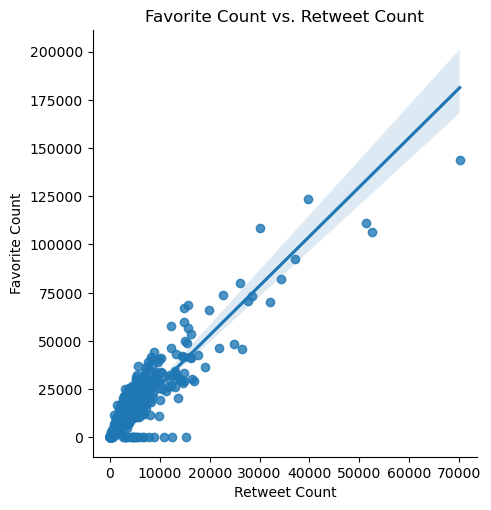

In [52]:
sns.lmplot(x="retweet_count", y="favorite_count", data=df);

plt.title('Favorite Count vs. Retweet Count');
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');

#### Most Frequent Dog Names World 

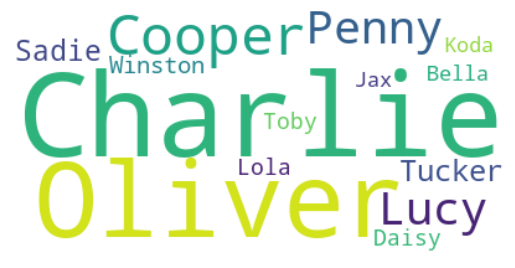

In [62]:
dog_names = df.name.value_counts()[1:15:1].to_dict()

wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(frequencies=dog_names)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Dog breeds based on tweet, retweet, and favorite count
* Most tweeted dog breeds are Golden Retriever, Labrador, Pembroke, Chihuahua, and Pug
* Most retweeted dog breeds are Labrador, Golden Retriever, Pembroke, Chihuahua, and Pug
* Most favored dog breeds are Golden Retriever, Pembroke, Labrador, ,Chihuahua, and Pug

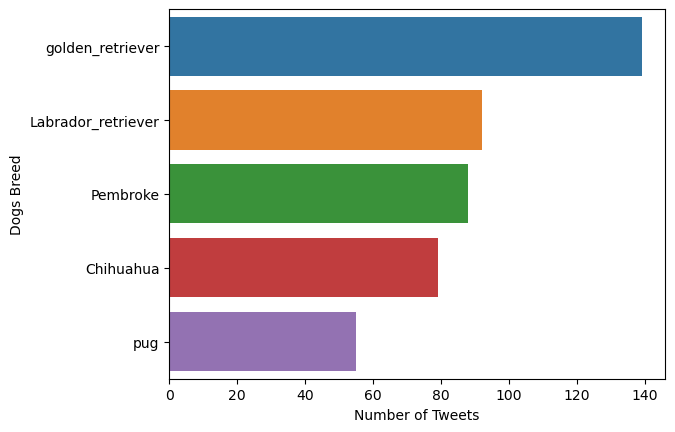

In [54]:
top5_breeds = df.p1.value_counts().iloc[:5].index
ax = sns.countplot(y='p1', data=df, order=top5_breeds)
ax.set(xlabel='Number of Tweets', ylabel='Dogs Breed')
plt.show();

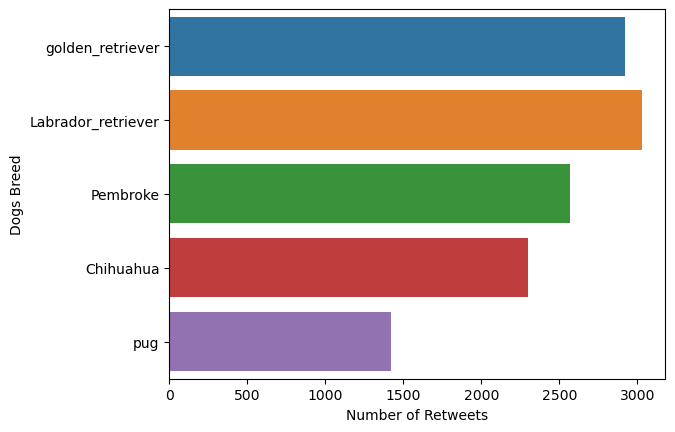

In [55]:
ax = sns.barplot(x='retweet_count', y='p1', data=df, order=top5_breeds, ci=None)
ax.set(xlabel='Number of Retweets', ylabel='Dogs Breed')
plt.show();

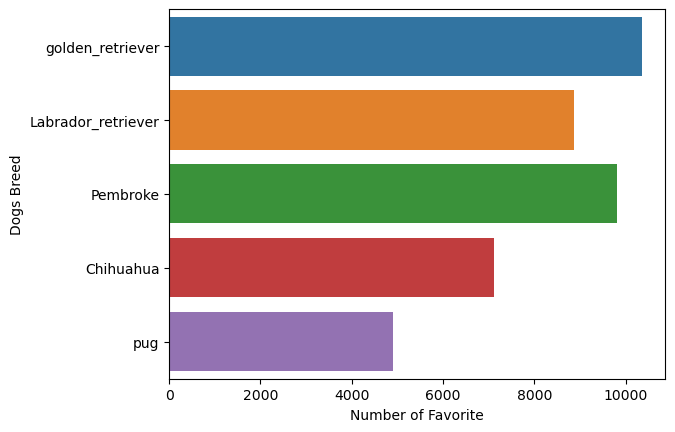

In [56]:
ax = sns.barplot(x='favorite_count', y='p1', data=df, order=top5_breeds, ci=None)
ax.set(xlabel='Number of Favorite', ylabel='Dogs Breed')
plt.show();

#### Sample a Labrador Retriever

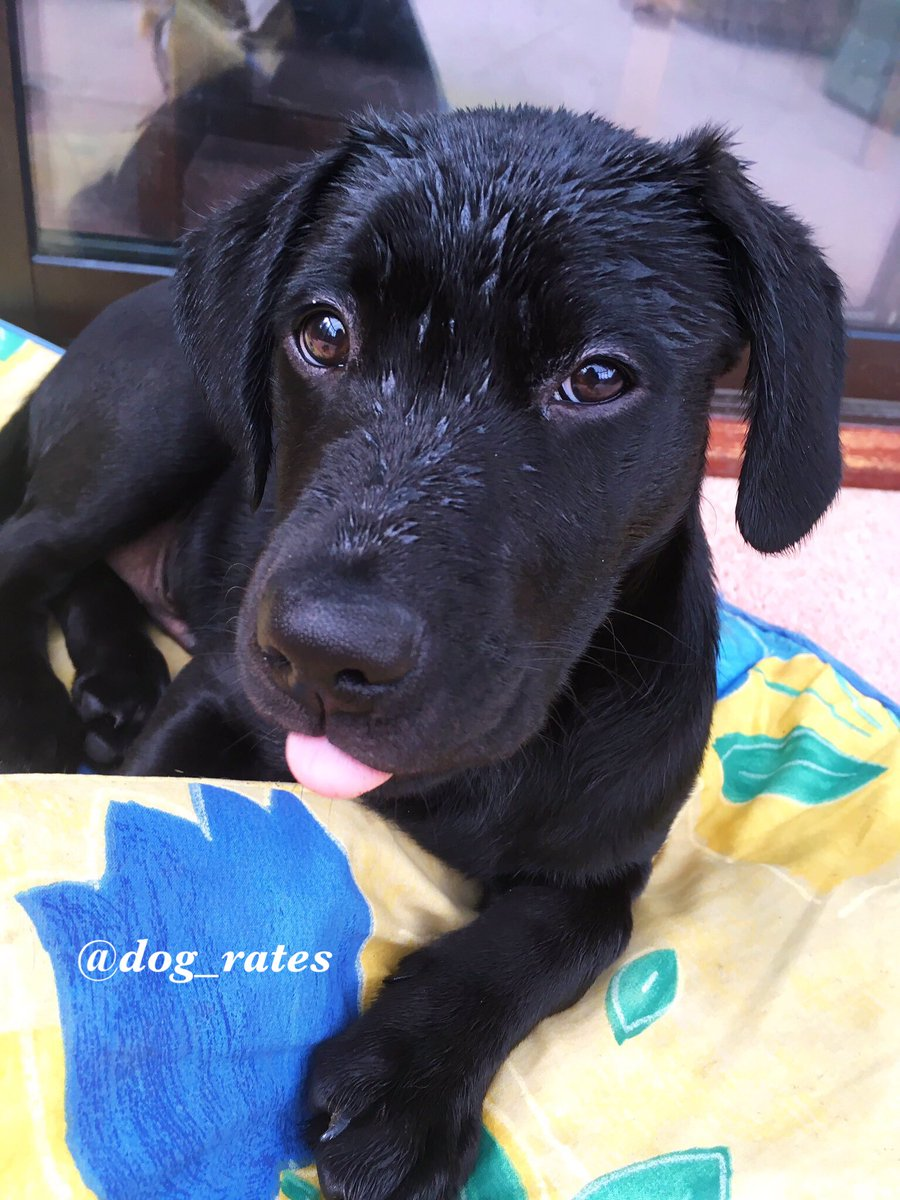

In [122]:
url = df.jpg_url[(df.p1 == 'Labrador_retriever')].sample()
Image(url.values[0])

## Resources
<div id='resources'/>


API terminologies: https://stackoverflow.com/questions/66156958/how-to-acess-tweets-with-bearer-token-using-tweepy-in-python

Table of contents: https://stackoverflow.com/questions/11948245/markdown-to-create-pages-and-table-of-contents/33433098

Asserting columns: https://stackoverflow.com/questions/28596493/asserting-columns-data-type-in-pandas

Categorical data: https://pandas.pydata.org/docs/user_guide/categorical.html

Pandas copy warning: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas, https://stackoverflow.com/questions/44723183/set-value-to-an-entire-column-of-a-pandas-dataframe

Melting duplicates: https://stackoverflow.com/questions/42933696/how-to-melt-a-dataframe-in-pandas-with-the-option-for-removing-na-values

Fastest way to cast: https://stackoverflow.com/a/68596394/10721627

Saved csv without index: https://stackoverflow.com/questions/20845213/how-to-avoid-pandas-creating-an-index-in-a-saved-csv

World Cloud: https://stackoverflow.com/questions/38465478/wordcloud-from-data-frame-with-frequency-python